In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results

# Partie 1 : Inspection des données & Nettoyages des données

<span style="color: #008080">@ Télécharger les fichiers de format csv et puis les palcent dans des dataframes nommés séparemment `loandown_2015` et `loandown_2016`. Les colonnes du fichier sont uniquement séparées par le virgule `,`. </span> 

In [88]:
loandown_2015 = pd.read_csv('2015-building-energy-benchmarking.csv', sep=',',low_memory=False)
loandown_2016 = pd.read_csv('2016-building-energy-benchmarking.csv', sep=',',low_memory=False)

<span style="color: #008080"> @ Nettoytage : On sépare la variable `Location` de `loandown_2015` en trois nouveaux colonnes : `Latitude, Longitude, Human_adress`.</span>

In [89]:
loandown_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

In [90]:
import json
import ast


data_2015= pd.DataFrame()
for idx, row in loandown_2015.iterrows():

    data_dict = ast.literal_eval(row['Location'])
    lat = data_dict['latitude']
    lon = data_dict['longitude']
    human_address = data_dict['human_address'] 

    normalize = pd.Series(json.loads(data_dict['human_address']))
    row = row.drop('Location')

    cols = list(row.index) + ['Latitude', 'Longitude', 'Human_adress'] + list(normalize.index)
    temp_df = pd.DataFrame([list(row) + [lat, lon, human_address] + list(normalize)], columns = cols )
    data_2015 = data_2015.append(temp_df).reset_index(drop=True)

<span style="color: #008080"> @ Nettoyage : On s'intéresse de près aux émmisions des bâtiments non destinés à l'habitation: `NON RESIDENTIEL` 
- On stock ces bâtiments dans un dataframe, on le nomme `data_2015`.</span>

In [91]:
data_2015=data_2015.loc[data_2015['BuildingType'].isin({'NonResidential','SPS-District K-12','Nonresidential COS'})] 

In [92]:
data_2015.shape

(1628, 53)

<span style="color: #008080"> @ Nettoyage : On s'intéresse de près aux émmisions des bâtiments non destinés à l'habitation: `NON RESIDENTIEL` 
- On stock ces bâtiments dans un dataframe, on le nomme `data_2016`.</span>

In [93]:
data_2016=loandown_2016.loc[loandown_2016['BuildingType'].isin({'NonResidential','SPS-District K-12','Nonresidential COS','Nonresidential WA'})] 
data_2016.shape

(1644, 46)

<span style="color: #008080"> @ Nettoyage : On supprime les lignes de valeurs "Low outlier et Hign outlier" dans la variable `Outlier` des datasets `data_2015` et `data_2016`.  </span>

In [94]:
data_2015=data_2015.drop((data_2015.loc[data_2015['Outlier']=='Low Outlier']).index)
data_2015=data_2015.drop((data_2015.loc[data_2015['Outlier']=='High Outlier']).index)
data_2016=data_2016.drop((data_2016.loc[data_2016['Outlier']=='Low outlier']).index)
data_2016=data_2016.drop((data_2016.loc[data_2016['Outlier']=='High outlier']).index)

<span style="color: #FF00FF">  @ Filtrage : On choisit les variables ce qui nous s'intéresse pour prédir `les émissions de CO²` et `la consommation total d'énergie`.
- Définiton des variables : https://www.opendatanetwork.com/dataset/data.seattle.gov/2bpz-gwpy
- 'GHGEmissions(MetricTonsCO2e)'
- 'SiteEnergyUse(kBtu)' : La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie, ajustée à ce que la propriété aurait consommé dans des conditions météorologiques moyennes sur 30 ans.


 </span>

In [95]:
data_2015=data_2015[[ 
    'BuildingType',
    'ListOfAllPropertyUseTypes',
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'TaxParcelIdentificationNumber',
    'CouncilDistrictCode',
    'Neighborhood',
    'Latitude',
    'Longitude',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'GHGEmissions(MetricTonsCO2e)',
    'ENERGYSTARScore',
    'SiteEnergyUse(kBtu)',
    'SteamUse(kBtu)',
    'Electricity(kBtu)',
    'NaturalGas(kBtu)',
    'OtherFuelUse(kBtu)']] 

In [96]:
data_2016=data_2016.rename(columns={'TotalGHGEmissions': 'GHGEmissions(MetricTonsCO2e)'})

In [97]:
data_2016=data_2016[[ 
    'BuildingType',
    'ListOfAllPropertyUseTypes',
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'TaxParcelIdentificationNumber',
    'CouncilDistrictCode',
    'Neighborhood',
    'Latitude',
    'Longitude',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'GHGEmissions(MetricTonsCO2e)',
    'ENERGYSTARScore',
    'SiteEnergyUse(kBtu)',
    'SteamUse(kBtu)',
    'Electricity(kBtu)',
    'NaturalGas(kBtu)']] 

<span style="color: #008080"> @ Création du DataFrame de données
-
- On fusionne les deux datasets `data_2015` et `data_2016` et les assigne à `data`.</span>

In [98]:
frames =[data_2015,data_2016] 
data = pd.concat(frames, ignore_index=True)
print(data.shape)

(3224, 20)


<span style="color: #008080"> @ Pré-traitement des données
-
- On transforme les varaibles `SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu) et OtherFuelUse(kBtu)` en pourcentage. Puit on change les noms de ces variables.</span>

In [99]:
data['SteamUse(kBtu)']=data['SteamUse(kBtu)']/data['SiteEnergyUse(kBtu)']
data['Electricity(kBtu)'] = data['Electricity(kBtu)']/data['SiteEnergyUse(kBtu)']
data['NaturalGas(kBtu)'] = data['NaturalGas(kBtu)']/data['SiteEnergyUse(kBtu)']
data['OtherFuelUse(kBtu)'] = data['OtherFuelUse(kBtu)']/data['SiteEnergyUse(kBtu)']

In [100]:
data=data.rename(columns={'SteamUse(kBtu)': 'SteamUse(percentage)','Electricity(kBtu)':'Electricity(percentage)','NaturalGas(kBtu)':'NaturalGas(percentage)','OtherFuelUse(kBtu)':'OtherFuelUse(percentage)'})

<span style="color: #008080"> @ NAN : Remplacer les valeurs manquantede de la colonne `OtherFuelUse(percentage)` par `0`.  </span>

In [101]:
data.loc[data['OtherFuelUse(percentage)'].isna()]=0

<span style="color: #008080"> @ NANs : On supprimer  toutes les lignes qui ne contient que les Nan dans la colonne `ENERGYSTARScore`, `ListOfAllPropertyUseTypes` et `NumberofFloors`. </span>

In [102]:
line_with_nan = ['ENERGYSTARScore','ListOfAllPropertyUseTypes','NumberofFloors']

for col in line_with_nan:
    index_with_nan = data.index[data[col].isnull()]
    data.drop(index_with_nan,axis=0, inplace=True);
    print("La taille de dataset data :", data.shape)

La taille de dataset data : (2722, 20)
La taille de dataset data : (2675, 20)
La taille de dataset data : (2672, 20)


<span style="color: #008080"> @ Convertir : On convetit la variable catégorielle `CouncilDistrictCode` en variables indicatrices.</span>

In [103]:
data = pd.get_dummies(data, columns=['CouncilDistrictCode'],drop_first= True)

<span style="color: #008080"> @ Nettoyage des données : On supprime les lignes qui ont des valeurs abérrantes : dans les colonnes `PropertyGFAParking`et `PropertyGFABuilding(s)`.
</span>

In [104]:
index_with_aberrant = data.index[data['PropertyGFAParking']==-2]
data.drop(index_with_aberrant,0, inplace=True)
index_with_aberrant = data.index[data['PropertyGFABuilding(s)']==-43310]
data.drop(index_with_aberrant,0, inplace=True)

/tmp/ipykernel_30695/1954599033.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(index_with_aberrant,0, inplace=True)
/tmp/ipykernel_30695/1954599033.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data.drop(index_with_aberrant,0, inplace=True)


<span style="color: #008080"> @ Nettoyage des données : Supprimer les lignes ne contient que les 0 :
</span>

In [105]:
features_numeriques = [ 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'GHGEmissions(MetricTonsCO2e)', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'SteamUse(percentage)',
       'Electricity(percentage)', 'NaturalGas(percentage)',
       'OtherFuelUse(percentage)']
ligne_nulle= data[features_numeriques]

In [106]:
index_0= np.where(~ligne_nulle.any(axis=1))[0]
print(len(index_0))

1634


In [107]:
index_0 = data.iloc[index_0, :].index
data.drop(index_0, axis=0, inplace= True)

In [108]:
data.shape

(1036, 26)

# Partie 2 : Analyse exploratoire des données

<span style="color: #008080"> @ On applique une échelle logarithmique aux targets : `SiteEnergyUse(kBtu)` et `GHGEmissions(MetricTonsCO2e)`. </span>

In [109]:
from math import sqrt, log
data['LGHGEmissions(MetricTonsCO2e)'] = data['GHGEmissions(MetricTonsCO2e)'].map(lambda x: log(x+1))
data['LSiteEnergyUse(kBtu)'] = data['SiteEnergyUse(kBtu)'].map(lambda x: log(x+1))
del data['GHGEmissions(MetricTonsCO2e)']
del data['SiteEnergyUse(kBtu)']

<span>  On liste toutes les variables que l'on va utliser dans les modèles, dans une liste `features_usefuls`.

In [110]:
features_usefuls = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors',        
                    'Latitude', 'Longitude', 'PropertyGFATotal',
                    'PropertyGFAParking', 'PropertyGFABuilding(s)',
                    'ENERGYSTARScore',
                    'SteamUse(percentage)','Electricity(percentage)', 
                    'NaturalGas(percentage)','OtherFuelUse(percentage)', 
                    'CouncilDistrictCode_1', 'CouncilDistrictCode_2', 
                    'CouncilDistrictCode_3', 'CouncilDistrictCode_4', 
                    'CouncilDistrictCode_5', 'CouncilDistrictCode_6',
                    'CouncilDistrictCode_7']

<span style="color: #008080"> @ `Standardiser` les données : On met les données à la même échelle avant d'appliquer le transformer `VarianceThreshold`  : </span>

In [111]:
from sklearn.preprocessing import StandardScaler 
std_scaler = StandardScaler()  
std_scaler.fit(data[features_usefuls])  
 
data[features_usefuls] = std_scaler.transform(data[features_usefuls])  

# Partie 3 : Préparation des variables pour le modèle

<span style="color: #008080"> @ Création des variables X avec `EnergyStarScore` et y. </span>

In [112]:
y_co2 = data['LGHGEmissions(MetricTonsCO2e)']

In [113]:
X_co2_energyStar = data[['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 
              'Latitude', 'Longitude', 
              'PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuilding(s)', 
              'ENERGYSTARScore',
              'SteamUse(percentage)', 'Electricity(percentage)',
              'NaturalGas(percentage)', 'OtherFuelUse(percentage)',
              'CouncilDistrictCode_1', 'CouncilDistrictCode_2',
              'CouncilDistrictCode_3', 'CouncilDistrictCode_4',
              'CouncilDistrictCode_5', 'CouncilDistrictCode_6',
              'CouncilDistrictCode_7']]   


<span style="color: #008080"> @ On sépare ensuite le jeu de donées en entraînement set et test set.
- Le jeu de test contiendra 30% des données. </span>

In [135]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_co2_energyStar,y_co2, test_size = 0.3)
print(X_train.shape, X_test.shape)

(725, 20) (311, 20)


# Partie 4 : Les modèles de prédiction d'émission de CO2

<span style="color: #008080"> @ Dummy Regressor 
-
- Création d'une baseline comme la référence de comparaison
 </span>

In [140]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import linear_model
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

# Prévision de l'échantillon de test
predDummy = dummy_regr.predict(X_test)

baseline_RMSE = np.sqrt(mean_squared_error(y_test, predDummy) )
baseline_r2 = r2_score(y_test, predDummy)
print("baseline_RMSE = %f, \nbaseline_r2 = %s"% (baseline_RMSE, baseline_r2))  
print("RMSE_normal = %s" % (np.sqrt(mean_squared_error(np.exp(y_test), np.exp(predDummy)))))

baseline_RMSE = 1.389376, 
baseline_r2 = -0.007242853690521134
RMSE_normal = 829.1857564807771


<span style="color: #008080"> @ Modèles linéaires
-
- Création du modèle
- Entraînement du modèle
- Evaluation du modèle
 </span>

In [137]:
from sklearn import linear_model

# On crée un modèle de régression linéaire
regLin = linear_model.LinearRegression()

# On entraîne ce modèle sur les données d'entrainement
regLin.fit(X_train,y_train)

# Prévision de l'échantillon de test
predLR = regLin.predict(X_test)

print("=== Sans Régularisation ===")
print("Weights: \n", regLin.coef_)


print("\n=== La performnce du modèle : Linéaire régression ===")
print('R2 = {}'.format(r2_score( y_test, predLR)))
print("RMSE = {}".format(np.sqrt(mean_squared_error(y_test, predLR) )))  # la racine carrée d'erreur quadratique moyenne

=== Sans Régularisation ===
Weights: 
 [ 1.88487220e-01 -1.49137214e-02 -8.06413457e-02  1.21978776e-01
  1.40478169e-01  3.82344555e-01  7.99407537e-03  4.41860078e-01
 -2.80299562e-01  4.83372360e-01  3.01839656e-01  1.00235223e+00
 -2.50417441e-02  2.99301858e-02 -9.99992760e-02 -8.16058546e-04
 -8.41719774e-02 -7.73257700e-02  2.16940594e-02  1.61777857e-01]

=== La performnce du modèle : Linéaire régression ===
R2 = 0.6420106489949692
RMSE = 0.8283001014580622


<span style="color: #FF00FF"> @ Ridge : 
-
- Création du modèle : Application de la régression `ridge` avec 50 paramètres.
- Entraînement du modèle : On effectue notre différentes régressions ridge avec les différents hyperparamètres. 
- Evaluation du modèle : On teste un certain nombre d'hyperparamètres `alphas` pour appliquer le `ridge`; 
</span>

In [138]:
from sklearn.linear_model import Ridge
n_alphas = 50
alphas = np.logspace(-5, 8, n_alphas) # l'échelle logarithmique obenue avec logspace
ridge = linear_model.Ridge()

coefs = []
errors = []
r2s = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    errors.append(np.sqrt(mean_squared_error(y_test, ridge.predict(X_test))))
    r2s.append(r2_score(y_test, ridge.predict(X_test))) #####!!!!!!!

<span style="color: #FF00FF"> @ Ridge :  
-
- On affiche `la valeur de l'erreur` la plus petite  à l'aide de la fonction `argmin`;
</span>

In [139]:
print("=== Régularisation Ridge ===")
print("Weights: \n", coefs[np.argmin(errors)])
print("Alphas associée à l'erreur la plus petite erreur : ", alphas[np.argmin(errors)])

print("\n=== La performnce du modèle : Régression Ridge ===")
print('R2 = {}'.format(r2s[np.argmin(errors)]))
print("RMSE = {}".format(errors[np.argmin(errors)]) )  # la racine carrée d'erreur quadratique moyenne

=== Régularisation Ridge ===
Weights: 
 [ 0.18203182 -0.01484931 -0.03760354  0.07657097  0.11595644  0.36054519
  0.01530684  0.41462506 -0.268261    0.25598018 -0.36284513  0.32413262
 -0.03761642  0.00678974 -0.11065147  0.00332218 -0.06547768 -0.04541745
  0.02495075  0.14879201]
Alphas associée à l'erreur la plus petite erreur :  23.29951810515372

=== La performnce du modèle : Régression Ridge ===
R2 = 0.6444175262434343
RMSE = 0.8255109417989152


<span style="color: #FF00FF"> @ Ridge : `GridSearchCV`
-
- Créatoin du modèle
- Performence du modèle
</span>


In [119]:
from sklearn.model_selection import GridSearchCV
# grille de valeurs du paramètre alpha à optimiser
n_alphas = 50
alphas = np.logspace(-5, 8, n_alphas).tolist()
param=[{"alpha":alphas}]

regRidge = GridSearchCV(linear_model.Ridge(), param,cv=5,n_jobs=-1)
regRidgeOpt=regRidge.fit(X_train, y_train)

# paramètre optimal
print("alpha = {}".format(regRidgeOpt.best_params_['alpha']))

# Prévision de l'échantillon de test
predRidgeOpt = regRidgeOpt.predict(X_test)

# Performence du modèle
print("\n=== La performnce du modèle : Régression Ridge avec GridSearchCV ===")
print("R2 =",r2_score(y_test,predRidgeOpt))
print("RMSE =",np.sqrt(mean_squared_error(y_test,predRidgeOpt)))

alpha = 23.29951810515372

=== La performnce du modèle : Régression Ridge avec GridSearchCV ===
R2 = 0.6448464969802487
RMSE = 0.862448164160441


<span style="color: #008080"> @ Lasso :
-
 Application de la régression `Lasso`
- On teste aussi un certain nombre d'hyperparamètres pour appliquer le lasso </span>

In [120]:
n_alphas = 300
alphas = np.logspace(-5, 3, n_alphas)

lasso = linear_model.Lasso()

coefs = []
errors = []
r2s =[]
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append( np.sqrt(mean_squared_error(y_test, lasso.predict(X_test))))
    r2s.append(r2_score(y_test,lasso.predict(X_test)))

/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.328e+01, tolerance: 1.313e-01
  model = cd_fast.enet_coordinate_descent(
/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.335e+01, tolerance: 1.313e-01
  model = cd_fast.enet_coordinate_descent(
/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.341e+01,

In [121]:
print("=== Régularisation Lasso ===")
print("Weights: \n", coefs[np.argmin(errors)])
print("alpha: \n", alphas[np.argmin(errors)])
print("\n=== La performnce du modèle : Régression Lasso ===")
print('R2 = {}'.format(r2s[np.argmin(errors)]))
print("RMSE = {}".format(errors[np.argmin(errors)]) )  # la racine carrée d'erreur quadratique moyenne

=== Régularisation Lasso ===
Weights: 
 [ 0.13895799  0.         -0.01583176  0.06612027  0.04337795  0.37037354
  0.          0.3759909  -0.28439595  0.12421354 -0.68259449  0.
  0.0009323  -0.         -0.00585139  0.05814816 -0.          0.
 -0.          0.20140392]
alpha: 
 0.018374437246107267

=== La performnce du modèle : Régression Lasso ===
R2 = 0.6473235543029374
RMSE = 0.8594352815716199


<span style="color: #008080"> @ Lasso : `GridSearchCV`
-
 </span>

In [122]:
from sklearn.model_selection import GridSearchCV
# grille de valeurs du paramètre alpha à optimiser
n_alphas = 300
alphas = np.logspace(-4, 3, n_alphas).tolist()
param=[{"alpha":alphas}]

regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(X_train, y_train)

# paramètre optimal
print("Train set : Meilleur paramètre alpha = %f" % regLassOpt.best_params_['alpha'])

# Prévision de l'échantillon de test
predLassOpt=regLassOpt.predict(X_test)

# Performence du modèle
print("\n=== La performnce du modèle : Régression Lasso avec GridSearchCV ===")
print("R2 = %f , \nRMSE = %s"% (r2_score(y_test,predLassOpt), np.sqrt(mean_squared_error(predLassOpt,y_test))))

/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.143e+00, tolerance: 1.041e-01
  model = cd_fast.enet_coordinate_descent(
/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.951e+00, tolerance: 1.022e-01
  model = cd_fast.enet_coordinate_descent(
/home/ying/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.572e+00,

Train set : Meilleur paramètre alpha = 0.001016

=== La performnce du modèle : Régression Lasso avec GridSearchCV ===
R2 = 0.642658 , 
RMSE = 0.8651017747572147


In [123]:
# Coefficients
regLasso=linear_model.Lasso(alpha=regLassOpt.best_params_['alpha'])
model_lasso=regLasso.fit(X_train,y_train)
model_lasso.coef_

array([ 0.16187742,  0.        , -0.08339594,  0.1907441 ,  0.11149242,
        0.42660108,  0.        ,  0.3786541 , -0.30795628,  0.14457783,
       -0.6986163 ,  0.        ,  0.02302261,  0.04018824, -0.        ,
        0.04848746, -0.07620458, -0.08208821, -0.02748931,  0.21264883])

In [124]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso conserve " + str(sum(coef != 0)) + 
      " variables et en supprime " +  str(sum(coef == 0)))

Lasso conserve 16 variables et en supprime 4


Text(0.5, 1.0, 'Coefficients du modèle lasso')

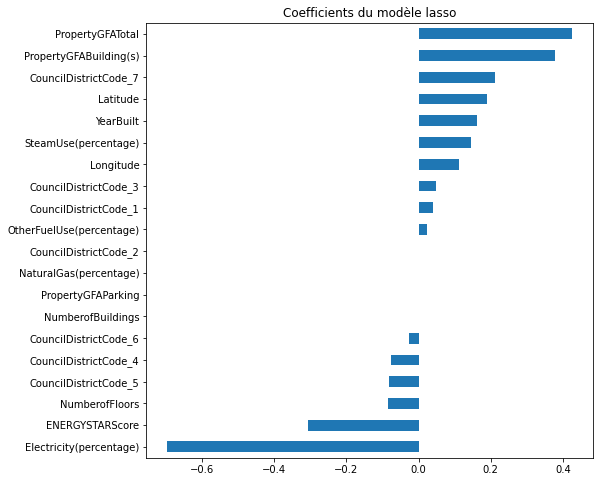

In [125]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 8.0)
imp_coef.plot(kind = "barh")
plt.title(u"Coefficients du modèle lasso")

<span style="color: #FF00FF"> @ SVR : `GridSearchCV`
-
- Créatoin du modèle
- Performence du modèle
</span>


In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
# grille de valeurs du paramètre à optimiser
param = {'kernel' : ('linear','rbf'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')},
model_SVR = SVR()
regSVR = GridSearchCV(estimator = model_SVR, param_grid = param,  cv = 5, n_jobs = -1, verbose = 2)

regSVROpt = regSVR.fit(X_train,y_train)

# paramètre optimal
print("\n Meilleur paramètre =", regSVROpt.best_params_)

# Prévision de l'échantillon de test
predSVROpt =regSVROpt.predict( X_test)

# Performence du modèle
print("\n=== La performnce du modèle : SVR ===")
print(" R2 = %f,\n RMSE = %s" % (regSVROpt.best_score_, np.sqrt(mean_squared_error(y_test, predSVROpt))))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.1s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.1s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.1s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.2s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END C=1, coef0=0.01, degree=3, gamma=auto, kernel=linear; total time=   0.2s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END ..C=1, coef0=0.01, degree=3, gamma=auto, kernel=rbf; total time=   0.1s
[CV] END .C=1, coef0=0.01, degree=3, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END C=1, coef0=0.01, degree=3, gamma=

<span style="color: #008080"> @ RandomForestRegression : `GridSearchCV` 
-
 </span>

In [127]:
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor()
para_grids = {
            "n_estimators" : [10,50,60],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False],
            "max_depth" : [6,8,10, 12]
        }


grid = GridSearchCV(estimator, para_grids,cv=5, scoring = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
forest = grid.best_estimator_

# Prévision de l'échantillon de test
reg_prediction=forest.predict(X_test)

print (grid.best_score_, "\n Les meilleurs paramètres :", grid.best_params_)
print(" R2 = %f, \n RMSE = %s" % (r2_score(y_test, reg_prediction),np.sqrt(mean_squared_error(y_test, reg_prediction))))
print(" RMSE_normal = %s" % (np.sqrt(mean_squared_error(np.exp(y_test), np.exp(reg_prediction)))))

-0.3703408108295149 
 Les meilleurs paramètres : {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 60}
 R2 = 0.841738, 
 RMSE = 0.5757233516733602
 RMSE_normal = 481.8769508848258


<span style="color: #008080"> @ RandomForestRegression : 
- On affiche les features selon l'ordre d'importance décroissant.
 </span>

In [128]:
importance = pd.Series(forest.feature_importances_, X_train.columns)
importance.sort_values(ascending=False)

Electricity(percentage)     0.334800
PropertyGFATotal            0.318496
PropertyGFABuilding(s)      0.162701
ENERGYSTARScore             0.068282
Latitude                    0.023579
NumberofFloors              0.021432
Longitude                   0.020388
NaturalGas(percentage)      0.017921
YearBuilt                   0.017568
PropertyGFAParking          0.003216
CouncilDistrictCode_1       0.002273
CouncilDistrictCode_2       0.001599
CouncilDistrictCode_4       0.001546
SteamUse(percentage)        0.001544
CouncilDistrictCode_7       0.001334
CouncilDistrictCode_3       0.001147
CouncilDistrictCode_6       0.001125
CouncilDistrictCode_5       0.001039
OtherFuelUse(percentage)    0.000009
NumberofBuildings           0.000000
dtype: float64

### @ Conclusion: 
Le modèle le plus performant pour prédire les émissions de CO2 avec le "EnergyStarScore" est le modèle `RandomForestRegression` avec r2 = 0.8417 et rmse = 0.5757.

 </span>